<a href="https://colab.research.google.com/github/sangttruong/Sessionality/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling Strategies for Complex Seasonality: A case study**
*Author: Sang Truong*

Department of Economics and Management

DePauw University, Greencastle, IN 46135

* Naive Sinusodal mode
* SARIMA
* Dynamic harmonic regression with ARIMA error
* TBATS

Reference: https://otexts.com/fpp2/transformations.html

## **Section 1. Introduction**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.linear_model import LinearRegression
from scipy import signal
from scipy.optimize import leastsq
import statsmodels.tsa.stattools as stattools
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.statespace.sarimax as sarimax

! pip install pyramid-arima
from pyramid.arima import auto_arima

! pip install tbats
from tbats import TBATS, BATS

drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/DemandForecast/'

In [72]:
raw = pd.read_csv(path + 'train.csv')
raw11 = raw[(raw.store == 1) & (raw.item == 1) ]
raw11

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


The data is recorded over 5 years: from the begining of 2013 to the end of 2017. We observe a annual seasional period in the data as shown in the below graph

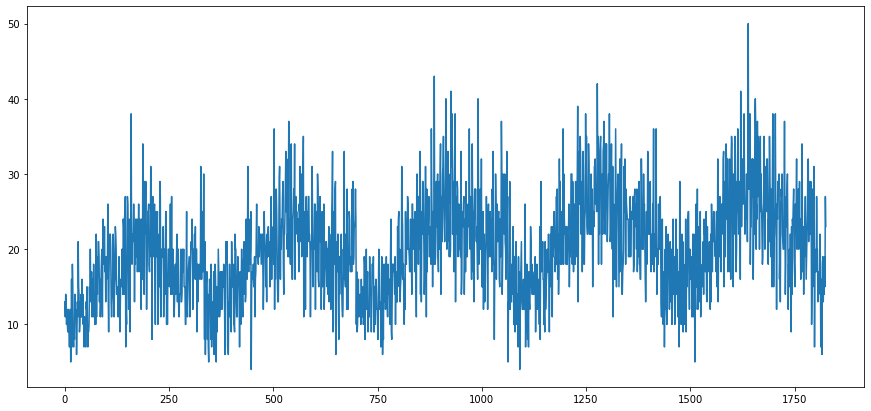

In [73]:
plt.figure(figsize = (15,7))
plt.plot(raw11['sales'])

In [0]:
data = raw11['sales'].values

## **Section 2. Sinusodal model**

Sinusodal model includes the trend component and the seasionality component:

$$ y = \alpha_{0} + \alpha_{1}t + \alpha_{2}sin(\alpha_{3}t + \alpha_{4})$$

We fit this model through the data by minimizing the sum of squared residual (SSE): 

$$ e_i = y_i - \hat{y_i} $$
$$ SSE = \sum_{i=1}^{k} e_i^2$$

In [63]:
N = len(data)
t = np.linspace(0, 4*np.pi, N)

# Generate guest parameters
guess_int = 10
guess_trend = 0.1
guess_amp = -5
guess_freq = 2
guess_phase = 2

# Define the function to optimize: residual
residual = lambda x: data - (x[0] + x[1]*t + x[2]*np.sin(x[3]*t+x[4]))
result = leastsq(residual, [guess_int, guess_trend, guess_amp, guess_freq, guess_phase], full_output=1)
est_int, est_trend, est_amp, est_freq, est_phase = result[0]
sse_sinusodal = sum((result[2]['fvec'])**2)
sse_sinusodal

52409.83543534297

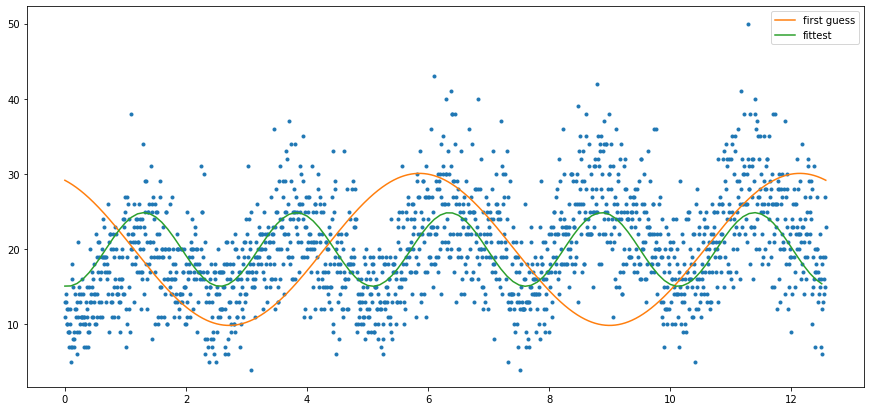

In [65]:
# Generate first guest curve
fine_t = np.arange(0,max(t),0.1)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

# Generate fittest curve
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Plot
plt.figure(figsize=(15,7))
plt.plot(t, data, '.')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='fittest')
plt.legend()
plt.show()

## **Section 3. SARIMA model**

Seasional ARIMA (or SARIMA) model includes 7 parameters: p, d, q, P, D, Q, and s. SARIMA(p, d, q)(P, D, Q)s is determined by four following polynomials: 
$$\phi(x) = 1 - \phi_{1}x - \phi_{2}x^2- \phi_{3}x^3 - ... - \phi_{p}x^p = 1 - \sum_{i=1}^{p}\phi_i x^i $$
$$\Phi(x) = 1 - \Phi_{1}x - \Phi_{2}x^2- \Phi_{3}x^3 - ... - \Phi_{p}x^P = 1 - \sum_{i=1}^{P}\Phi_i x^i $$
$$\psi(x) = 1 - \psi_{1}x - \psi_{2}x^2- \psi_{3}x^3 - ... - \psi_{q}x^p = 1 - \sum_{i=1}^{q}\psi_i x^i $$
$$\Psi(x) = 1 - \Psi_{1}x - \Psi_{2}x^2- \Psi_{3}x^3 - ... - \Psi_{Q}x^p = 1 - \sum_{i=1}^{Q}\Psi_i x^i $$

Recall the differential notation for trend-stationalizing time-series:
$$ \nabla_s Y_t = Y_t - Y_{t-s} $$

SARIMA(p, d, q)(P, D, Q)s where $X_t$ is the white noise process:
$$\phi(B)\Phi(B)\nabla^d \nabla_s^D Y_{t} = \psi(B)\Psi(B)X_{t} $$

Note that SARIMA can only model 1 seasional period (by parameter $s$). 

We search for parameters set by evaluating the partial autocorrelation function as below. PACF shows that there is a strong correlation between sales of day t and day t-7, indicating a weekly seasional period. 

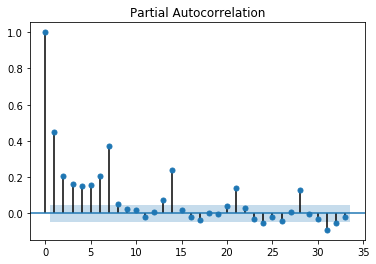

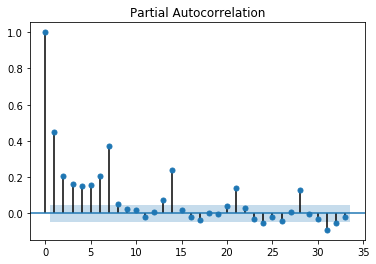

In [71]:
tsaplots.plot_pacf(data)

### **Section 3.1. Manual turning parameters**

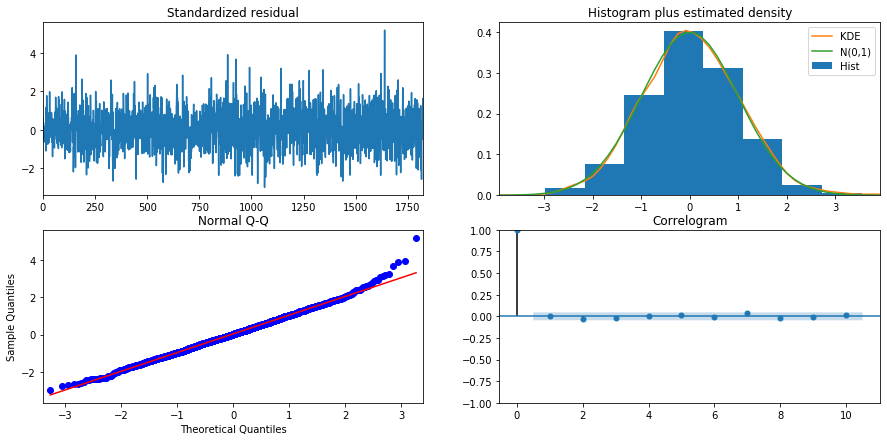

In [105]:
sarima = sarimax.SARIMAX(data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
sarima = sarima.fit()
pred = sarima.predict()
sarima.plot_diagnostics(figsize=(15, 7))
plt.show()

In [106]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1826
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -5413.151
Date:                           Mon, 11 Nov 2019   AIC                          10836.301
Time:                                   16:41:10   BIC                          10863.851
Sample:                                        0   HQIC                         10846.463
                                          - 1826                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.003    313.643      0.000       0.987       1.000
ma.L1         -0.8871      0.013    -70.780      0.000      -0.912      -0.863
ar.S.L7        0.9999      0.000   4722.501      0.000       0.999       1.000
ma.S.L7       -0.9910      0.007   -144.023      0.000      -1.005      -0.978
sigma2        21.7153      0.663     32.749      0.000      20.416      23.015
===================================================================================
Ljung-Box (Q):                       43.23   Jarque-Bera (JB):                29.28
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

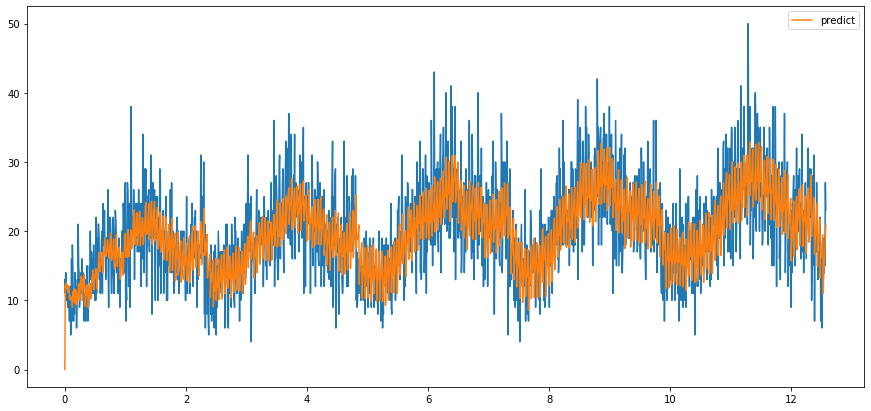

In [107]:
plt.figure(figsize=(15,7))
plt.plot(t, data)
plt.plot(t, pred, label='predict')
plt.legend()
plt.show()

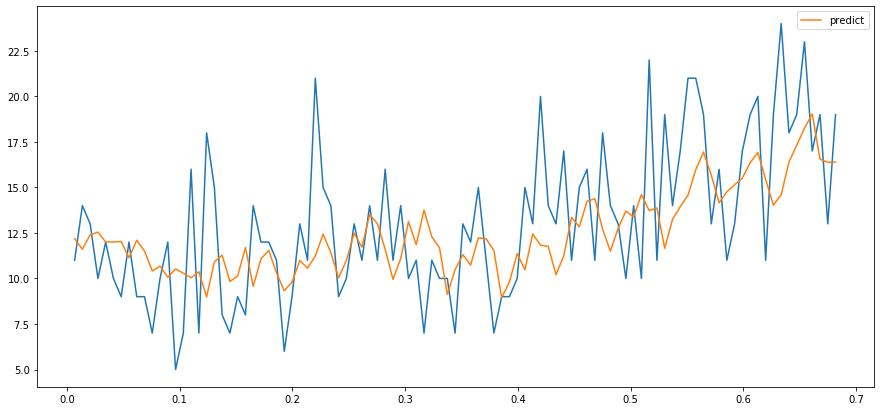

In [108]:
plt.figure(figsize=(15,7))
plt.plot(t[1:100], data[1:100])
plt.plot(t[1:100], pred[1:100], label='predict')
plt.legend()
plt.show()

In [111]:
sse_sarima = sum(sarima.resid**2)
sse_sarima

40103.51522307859

### **Section 3.2. Automatically turning parameters**

In [83]:
sarima = auto_arima(data,
                   start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5,
                   start_P=0, D=None, start_Q=1, max_P=5, max_D=2, max_Q=5,
                   m = 7, seasonal=True)
sarima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1826
Model:             SARIMAX(0, 1, 1)x(1, 0, 2, 7)   Log Likelihood               -5411.689
Date:                           Mon, 11 Nov 2019   AIC                          10835.378
Time:                                   15:58:38   BIC                          10868.434
Sample:                                        0   HQIC                         10847.572
                                          - 1826                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.597e-06   2.21e-05     -0.208      0.835   -4.79e-05    3.87e-05
ma.L1         -0.8953      0.011    -80.780      0.000      -0.917      -0.874
ar.S.L7        0.9998      0.000   2718.843      0.000       0.999       1.001
ma.S.L7       -0.9506      0.023    -40.871      0.000      -0.996      -0.905
ma.S.L14      -0.0397      0.023     -1.713      0.087      -0.085       0.006
sigma2        21.7649      0.673     32.337      0.000      20.446      23.084
===================================================================================
Ljung-Box (Q):                       40.89   Jarque-Bera (JB):                24.25
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
sse_sarima = sum(sarima.resid()**2)
sse_sarima

40237.23680197961

In [0]:
pred = sarima.predict_in_sample()
plt.figure(figsize=(15,7))
plt.plot(t, data)
plt.plot(t, pred, label='predict')
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(15,7))
plt.plot(t[1:100], data[1:100])
plt.plot(t[1:100], pred[1:100], label='predict')
plt.legend()
plt.show()

## **Section 4. Dynamic Harmonic Regression with ARIMA error**

Dynamic harmonic regression with multiple seasonal periods:
https://robjhyndman.com/nyc2018/3-1-Dynamic-Regression.pdf
https://otexts.com/fpp2/dhr.html

What is the functional form? 


In [0]:
raw11 = raw[(raw.store == 1) & (raw.item == 1) ]

In [0]:
y = raw11

### **Section 4.1. Capturing annual seasional period by Fourier term**

In [0]:
# Turning K for annual seasional period
for i in range(1,7):
  exog = pd.DataFrame({'date': pd.to_datetime(y['date'])})
  exog = exog.set_index(pd.PeriodIndex(exog.date.values, freq='D'))
  exog['sin365_' + str(i)] = np.sin(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog['cos365_' + str(i)] = np.cos(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog = exog.drop(columns=['date'])
  sarimaF = auto_arima(y['sales'], exog, seasonal=True, m=7)
  print('For K =', i, 'AIC = ', sarimaF.aic())
  
  # For K = 1 AIC =  10822.680014478346
  # For K = 2 AIC =  10846.965545424478
  # For K = 3 AIC =  10831.829259631792
  # For K = 4 AIC =  10841.10811008813
  # For K = 5 AIC =  10836.409388610427
  # For K = 6 AIC =  10834.99890909507

In [0]:
# For K = 1
  i = 1
  exog = pd.DataFrame({'date': pd.to_datetime(y['date'])})
  exog = exog.set_index(pd.PeriodIndex(exog.date.values, freq='D'))
  exog['sin365_' + str(i)] = np.sin(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog['cos365_' + str(i)] = np.cos(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog = exog.drop(columns=['date'])
  sarimaF = auto_arima(y['sales'], exog, seasonal=True, m=7)

In [149]:
sarimaF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1826
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 7)   Log Likelihood               -5401.340
Date:                           Mon, 11 Nov 2019   AIC                          10822.680
Time:                                   17:50:35   BIC                          10877.773
Sample:                                        0   HQIC                         10843.003
                                          - 1826                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.126e-06   4.64e-05      0.067      0.946   -8.78e-05     9.4e-05
x1            -0.9662      0.318     -3.037      0.002      -1.590      -0.343
x2            -4.8111      0.305    -15.777      0.000      -5.409      -4.213
ar.L1          0.0809      0.025      3.300      0.001       0.033       0.129
ma.L1         -0.9743      0.005   -207.171      0.000      -0.984      -0.965
ar.S.L7        0.0478      0.103      0.463      0.644      -0.155       0.250
ar.S.L14       0.9503      0.103      9.216      0.000       0.748       1.152
ma.S.L7       -0.0218      0.098     -0.222      0.824      -0.214       0.171
ma.S.L14      -0.9380      0.095     -9.854      0.000      -1.125      -0.751
sigma2        21.6589      0.679     31.912      0.000      20.329      22.989
===================================================================================
Ljung-Box (Q):                       73.65   Jarque-Bera (JB):                25.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

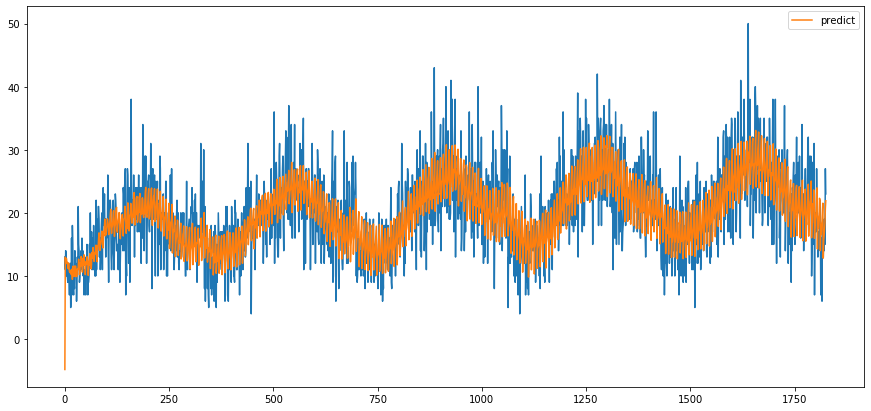

In [148]:
pred = sarimaF.predict_in_sample(exog)
plt.figure(figsize=(15,7))
plt.plot(data)
plt.plot(pred, label='predict')
plt.legend()
plt.show()

### **Section 4.2. Capturing annual seasional and weekly period by Fourier term**

In [0]:
# K = 1
# For K = 5 AIC = 10964.461584832832
exog = pd.DataFrame({'date': pd.to_datetime(y['date'])})
exog = exog.set_index(pd.PeriodIndex(exog.date.values, freq='D'))
for i in range(1,6):
  exog['sin365_' + str(i)] = np.sin(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog['cos365_' + str(i)] = np.cos(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog['sin7_' + str(i)] = np.sin(2 * i * np.pi * exog.index.dayofweek / 7)
  exog['cos7_' + str(i)] = np.cos(2 * i * np.pi * exog.index.dayofweek / 7)
exog = exog.drop(columns=['date'])

In [0]:
sarimaF = auto_arima(y['sales'], exog,
                     start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5, seasonal=False)
sarimaF.summary()
pred = sarimaF.predict_in_sample(exog)

In [186]:
sarimaF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1825
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5333.569
Method:                       css-mle   S.D. of innovations              4.493
Date:                Mon, 11 Nov 2019   AIC                          10715.139
Time:                        18:11:35   BIC                          10847.363
Sample:                             1   HQIC                         10763.914
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.064      0.039       0.000       0.007
x1             0.0829      0.003     23.914      0.000       0.076       0.090
x2            -0.0163      0.004     -4.502      0.000      -0.023      -0.009
x3            -0.0759      0.131     -0.580      0.562      -0.333       0.181
x4            -2.4666      0.131    -18.839      0.000      -2.723      -2.210
x5            -0.0021      0.006     -0.364      0.716      -0.013       0.009
x6            -0.0324      0.006     -5.573      0.000      -0.044      -0.021
x7             0.4331   9919.480   4.37e-05      1.000   -1.94e+04    1.94e+04
x8            -1.4099        nan        nan        nan         nan         nan
x9             0.0494      0.008      6.017      0.000       0.033       0.066
x10           -0.0354      0.008     -4.283      0.000      -0.052      -0.019
x11            0.1472        nan        nan        nan         nan         nan
x12           -1.4663   7.86e+04  -1.87e-05      1.000   -1.54e+05    1.54e+05
x13            0.0135      0.011      1.255      0.210      -0.008       0.035
x14            0.0165      0.011      1.525      0.127      -0.005       0.038
x15           -0.1472        nan        nan        nan         nan         nan
x16           -1.4663   7.86e+04  -1.87e-05      1.000   -1.54e+05    1.54e+05
x17            0.0469      0.013      3.510      0.000       0.021       0.073
x18            0.0399      0.013      2.983      0.003       0.014       0.066
x19           -0.4331   9919.480  -4.37e-05      1.000   -1.94e+04    1.94e+04
x20           -1.4099        nan        nan        nan         nan         nan
ar.L1.D.y      0.0353      0.024      1.473      0.141      -0.012       0.082
ma.L1.D.y     -0.9854      0.006   -177.126      0.000      -0.996      -0.974
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           28.3010           +0.0000j           28.3010            0.0000
MA.1            1.0148           +0.0000j            1.0148            0.0000
-----------------------------------------------------------------------------
"""

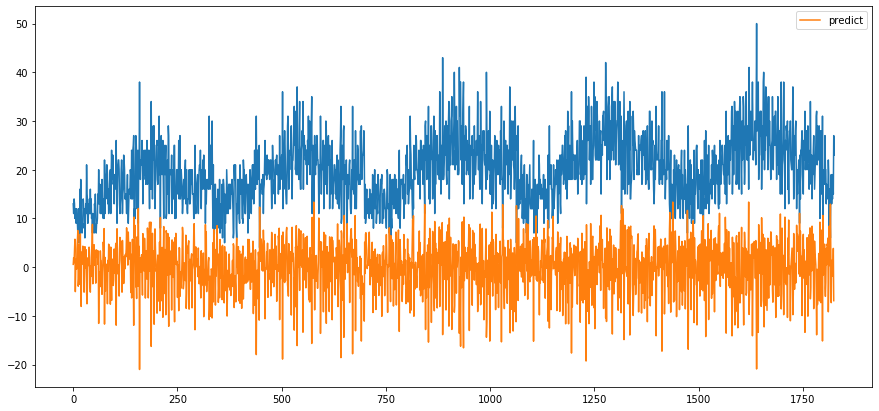

In [187]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.plot(pred, label='predict')
plt.legend()
plt.show()

## **Section 5. TBATS model**

In [0]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(data)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)